In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5

In [ ]:
# ENV["JULIA_DEBUG"] = "BAT"

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements

In [3]:
using Revise
using BAT 

In [4]:
conv_mat = load("../data/experiment/dataset_2/m2/conv_matrix.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_3"],
)

(cam_1 = [0.16922280747049184 0.14725876292577664 … 9.804539409837765e-19 9.91744496519356e-19; 0.13698894345024634 0.12178663702930428 … 9.52516847848642e-19 9.559768551032814e-19; … ; 3.392849462608846e-8 3.527635033404157e-8 … 0.06746695270012963 0.06747823881205484; 3.392849462607551e-8 3.527635033402785e-8 … 0.07032651372714573 0.07033882138934304], cam_2 = [0.2489166139447179 0.22131578631138504 … 2.660536939905101e-19 2.416060283321948e-19; 0.19738388190897505 0.1792450446630506 … 2.683303555266501e-19 2.4407251042449397e-19; … ; 6.893366827562823e-5 5.917531632521968e-5 … 0.06742289307540646 0.06743419376894891; 9.06994723790053e-5 7.783372485099013e-5 … 0.07027846175518433 0.0702907845309871], cam_3 = [0.12876476555810015 0.11096323591192903 … 9.114644254616891e-19 8.462095254466114e-19; 0.10510231890436048 0.09253546225811259 … 9.511992741342331e-19 9.04229043901602e-19; … ; 3.3471334001937267e-8 3.44507918466309e-8 … 0.06749057222978075 0.06750185016109878; 3.347133400192821

In [ ]:
# Toy Event

images = load("../data/experiment/dataset_2/m2/simulated_events.jld2")["array"];
event = images[2];

In [5]:
# Experiment Event: 

images = load("../data/experiment/dataset_2/m2/images.jld2");

event_number = 2

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
)


(cam_1 = [11 0 … 0 695; 25 0 … 0 0; … ; 0 14 … 0 0; 145 8 … 29 132], cam_2 = [0 0 … 0 0; 217 0 … 0 0; … ; 0 127 … 0 0; 0 0 … 115 0], cam_3 = [454 86 … 0 0; 190 129 … 0 0; … ; 9 91 … 7 14; 20 4 … 10 10], cam_4 = [23 18 … 24 19; 18 20 … 27 14; … ; 30 15 … 24 15; 36 19 … 25 14], population = 26.462099075317383)

In [6]:
include("../src/likelihood.jl")
include("../src/utill.jl")

corner_plots (generic function with 1 method)

In [7]:
# param_truth = (
#         tr_size = [0.15, 0.15],
#         ang_spr = [4.0, 4.0],
#         s_waist = [2.9,],
#         μ_x = [35,35,20,35], 
#         μ_y = [35,35,20,35], 
#         σ_x = [0,0,0,0], 
#         σ_y = [0,0,0,0], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );


param_truth = (
        tr_size = [0.2, 0.2],
        ang_spr = [4.0, 4.0],
        s_waist = [2.9,],
        μ_x = [35,35,20,35], 
        μ_y = [35,35,20,35], 
        σ_x = [3.07,3.95,2.13,2.16], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

In [8]:
log_likelihood = let e = event, c = conv_matrices
    
    params -> begin
        
        ll = zero(Float64)
        ll += cam_likelihood(params, e.cam_1, e.population, c.cam_1, 1)
        ll += cam_likelihood(params, e.cam_2, e.population, c.cam_2, 2)
        ll += cam_likelihood(params, e.cam_3, e.population, c.cam_3, 3)
        ll += cam_likelihood(params, e.cam_4, e.population, c.cam_4, 4)
    
        return LogDVal(ll)
        
    end
end

#14 (generic function with 1 method)

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [35,35,20,35], 
        μ_y = [35,35,20,35], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# 30 iterationsfro convergence 

In [ ]:
β_min = 0.7
β_max = 1.3

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]], 
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );

# #40 iterations for convergence 

In [ ]:
β_min = 0.6
β_max = 1.4

prior = NamedTupleDist(
        tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
        ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
        s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
        μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
                β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
                β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
                β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
        μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
                β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
                β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
                β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
        σ_x = [0,0,0,0], 
        σ_y = [0,0,0,0], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
    
        int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
                β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
                β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
                β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
        s_cam = [0.0, 1.478, 15.026, 23.1150],
    );

# 43 chains for convergence 

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..208,
#     max_nsamples_init = 600,
#     max_nsteps_init = 600,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 1700,
#     max_nsteps_per_cycle = 1700,
#     max_time_per_cycle = Inf,
#     max_ncycles = 60
# );

# nsamples = 6*10^4
# nchains = 4;

In [9]:
# resolution + prior AWAKE 

β_min = 0.7
β_max = 1.3

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         σ_y = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], # change prior range
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [truncated(Normal(3.07, 0.5), 0, 5), truncated(Normal(3.95, 0.5), 0, 5), truncated(Normal(2.13, 0.5), 0, 5), truncated(Normal(2.16, 0.5), 0, 5)], 
#         σ_y = [0 , 0 , 0 , 0 ], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

# prior = NamedTupleDist(
#         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#         ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
#         s_waist = [Normal(2.9, 0.03)],
#         μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
#         σ_x = [3.07, 3.95, 2.13, 2.16],
#         σ_y = [3.07 , 3.95, 2.13, 2.16], 
#         δ_x = [0.0271,0.0216,0.114,3*0.0303], 
#         δ_y = [0.0305,0.0234,0.125,3*0.0298],
#         int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
#         s_cam = [0.0, 1.478, 15.026, 23.1150], 
#     );

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
        ang_spr = [truncated(Normal(4, 2), 2, 6), truncated(Normal(4, 2), 2, 6)], 
        s_waist = [Normal(2.9, 0.03)],
        μ_x = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        μ_y = [20 .. 40, 20 .. 40, 10 .. 30, 20 .. 40],
        σ_x = [0, 0, 0, 0],
        σ_y = [0 , 0 , 0 , 0 ], 
        δ_x = [0.0271,0.0216,0.114,3*0.0303], 
        δ_y = [0.0305,0.0234,0.125,3*0.0298],
        int_coeff  = [35147.44, 50235.06, 10096.64, 33406.9],
        s_cam = [0.0, 1.478, 15.026, 23.1150], 
    );


# #40 iterations for convergence 
# res 1: mean([0.0874, 0.0895] ./ [0.0270999, 0.03049999999999997])
#res2: [0.021599999999999397, 0.023400000000000087] ./ [0.0861, 0.0918]
# res 3: mean([0.303, 0.201] ./ [0.11400000000000077, 0.125])
# res4: mean([0.202, 0.189] ./ [0.030303030303030304, 0.02981267596704524] ) / 3

In [ ]:
# β_min = 0.9
# β_max = 1.1

# prior = NamedTupleDist(
#         tr_size = [β_min*param_truth.tr_size[1]..β_max*param_truth.tr_size[1], β_min*param_truth.tr_size[2]..β_max*param_truth.tr_size[2]],
    
#         ang_spr = [β_min*param_truth.ang_spr[1]..β_max*param_truth.ang_spr[1], β_min*param_truth.ang_spr[2]..β_max*param_truth.ang_spr[2]],
    
#         s_waist = [β_min*param_truth.s_waist[1]..β_max*param_truth.s_waist[1],],
    
#         μ_x = [ β_min*param_truth.μ_x[1]..β_max*param_truth.μ_x[1],
#                 β_min*param_truth.μ_x[2]..β_max*param_truth.μ_x[2],
#                 β_min*param_truth.μ_x[3]..β_max*param_truth.μ_x[3],
#                 β_min*param_truth.μ_x[4]..β_max*param_truth.μ_x[4]], 
    
#         μ_y = [ β_min*param_truth.μ_y[1]..β_max*param_truth.μ_y[1],
#                 β_min*param_truth.μ_y[2]..β_max*param_truth.μ_y[2],
#                 β_min*param_truth.μ_y[3]..β_max*param_truth.μ_y[3],
#                 β_min*param_truth.μ_y[4]..β_max*param_truth.μ_y[4]],
    
#         σ_x = [0,0,0,0], 
#         σ_y = [0,0,0,0], 
#         δ_x = [ β_min*param_truth.δ_x[1]..β_max*param_truth.δ_x[1],
#                 β_min*param_truth.δ_x[2]..β_max*param_truth.δ_x[2],
#                 β_min*param_truth.δ_x[3]..β_max*param_truth.δ_x[3],
#                 β_min*param_truth.δ_x[4]..β_max*param_truth.δ_x[4]],
    
#         δ_y = [ β_min*param_truth.δ_y[1]..β_max*param_truth.δ_y[1],
#                 β_min*param_truth.δ_y[2]..β_max*param_truth.δ_y[2],
#                 β_min*param_truth.δ_y[3]..β_max*param_truth.δ_y[3],
#                 β_min*param_truth.δ_y[4]..β_max*param_truth.δ_y[4]],
    
#         int_coeff  = [ β_min*param_truth.int_coeff[1]..β_max*param_truth.int_coeff[1],
#                 β_min*param_truth.int_coeff[2]..β_max*param_truth.int_coeff[2],
#                 β_min*param_truth.int_coeff[3]..β_max*param_truth.int_coeff[3],
#                 β_min*param_truth.int_coeff[4]..β_max*param_truth.int_coeff[4]], 
    
#         s_cam = [0.0, 1.478, 15.026, 23.1150],
#     );

# init = MCMCInitStrategy(
#     init_tries_per_chain = 100..200,
#     max_nsamples_init = 2000,
#     max_nsteps_init = 2000,
#     max_time_init = Inf
# )

# burnin = MCMCBurninStrategy(
#     max_nsamples_per_cycle = 5000,
#     max_nsteps_per_cycle = 5000,
#     max_time_per_cycle = Inf,
#     max_ncycles = 45
# );

# algorithm = MetropolisHastings()


In [13]:
posterior = PosteriorDensity(log_likelihood, prior);

In [14]:
tuning = AdaptiveMetropolisTuning(
    λ = 0.5,
    α = 0.15..0.25,
    β = 1.5,
    c = 1e-4..1e2,
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCInitStrategy(
    init_tries_per_chain = 100..200,
    max_nsamples_init = 600,
    max_nsteps_init = 600,
    max_time_init = Inf
)

burnin = MCMCBurninStrategy(
    max_nsamples_per_cycle = 4000,
    max_nsteps_per_cycle = 4000,
    max_time_per_cycle = Inf,
    max_ncycles = 160
);

algorithm = MetropolisHastings()

MetropolisHastings(BAT.MvTDistProposal(1.0), RepetitionWeighting{Int64}())


In [15]:
nsamples = 3*10^5
nchains = 4;

In [16]:
@time samples = bat_sample(
    posterior, (nsamples, nchains), algorithm,
    max_nsteps = nsamples,
    max_time = Inf,
    tuning = tuning,
    init = init,
    burnin = burnin,
    convergence = convergence,
    strict = true,
    filter = true
).result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

1939.228077 seconds (394.97 M allocations: 472.972 GiB, 3.99% gc time)


In [ ]:
# BAT.bat_write("test.hdf5", unshaped.(samples))
# CSV.write(SAVE_PATH*file_name_*".csv", output_sp_ms.info)

In [ ]:
# int = bat_integrate(samples)

In [17]:
mode(samples)

ShapedAsNT((tr_size = [0.13791612202068879, 0.14890386661781865], ang_spr = [4.639534966372601, 5.048228272270644], s_waist = [2.8998448183935777], μ_x = [36.939622918585286, 37.397467521611, 20.18951142712615, 33.683670441794355], μ_y = [31.702052426527175, 32.475223575004385, 21.290991443202817, 35.34300151735306], σ_x = [0, 0, 0, 0], σ_y = [0, 0, 0, 0], δ_x = [0.0271, 0.0216, 0.114, 0.09090000000000001], δ_y = [0.0305, 0.0234, 0.125, 0.08940000000000001], int_coeff = [35147.44, 50235.06, 10096.64, 33406.9], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [ ]:
bat_integrate(samples)

In [27]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/wo_resolution.hdf5", unshaped.(samples))

In [ ]:
(samples)

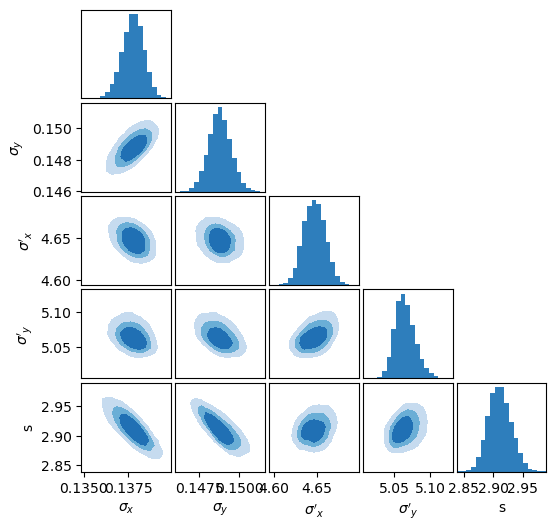

In [18]:
dims = [1,2,3,4,5,]
names = [L"\sigma_x", L"\sigma_y", L"\sigma'_x", L"\sigma'_y", "s", "6", "7", "8", "9"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

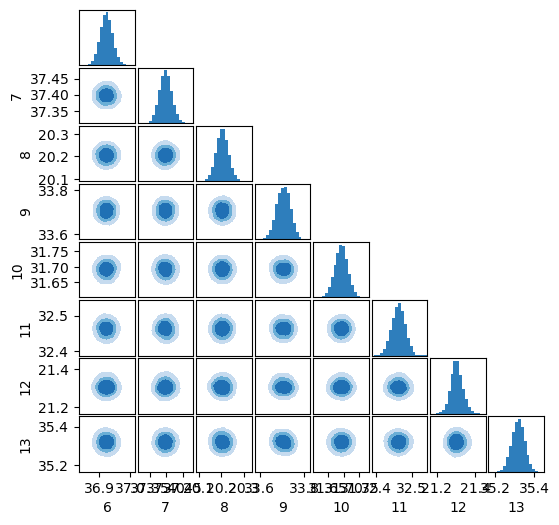

In [19]:
dims = [6,7,8,9,10,11,12, 13]
names = ["6", "7", "8", "9", "10", "11", "12", "13"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [20]:
dims = [14,15,16,17]
names = ["14", "15", "16", "17"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 13×291201 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [14, 1:291201]

In [ ]:
dims = [14,15,16,17, 18, 19, 20, 21]
names = ["14", "15", "16", "17", "18", "19", "20", "21"]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [21]:
bat_eff_sample_size(unshaped.(samples.v)).result

13-element Array{Float64,1}:
 2937.722880891088
 2701.0915816985794
 4879.482151113801
 4564.823977898361
 2599.4258665456823
 5571.797378243738
 4632.828285743508
 5978.860324983455
 4217.051282405084
 4317.039510258215
 5133.344322865497
 5866.198427699636
 5186.623292096342

In [22]:
bat_eff_sample_size(unshaped.(samples.v)).result ./ length(samples)

13-element Array{Float64,1}:
 0.010088299425108733
 0.00927569473215607
 0.016756405888420027
 0.01567585268559641
 0.008926569162007281
 0.019133853861228973
 0.015909383160578116
 0.020531730059249298
 0.014481582420407499
 0.014824947408347552
 0.01762818233064274
 0.020144843004315356
 0.01781114519557399

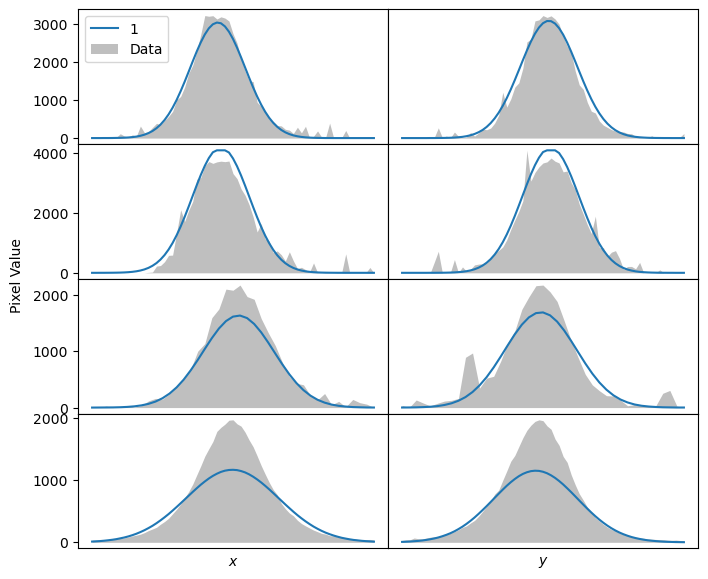

PyObject Text(0.04, 0.5, 'Pixel Value')

In [23]:
plot_cam_crossections([mode(samples)[1],], event, conv_matrices)

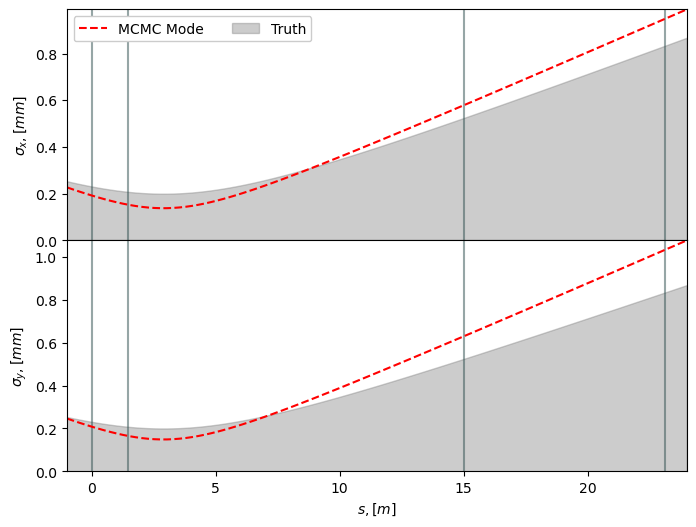

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [24]:
plot_vector = [param_truth, mode(samples)[1],]

plot_envelop_trajectory(plot_vector,  labels = ["Truth", "MCMC Mode"])

In [25]:
@show round.(unshaped(std(samples)), sigdigits=3)

round.(unshaped(std(samples)), sigdigits = 3) = [0.00061, 0.000705, 0.0125, 0.0141, 0.0192, 0.0202, 0.0184, 0.0277, 0.0303, 0.0212, 0.0189, 0.0319, 0.0329]


13-element ElasticArrays.ElasticArray{Float64,1,0,Array{Float64,1}}:
 0.00061
 0.000705
 0.0125
 0.0141
 0.0192
 0.0202
 0.0184
 0.0277
 0.0303
 0.0212
 0.0189
 0.0319
 0.0329

In [26]:
unshaped(std(samples))

13-element ElasticArrays.ElasticArray{Float64,1,0,Array{Float64,1}}:
 0.0006099144631742352
 0.0007045209513150908
 0.012521456635079727
 0.014086301039868375
 0.019216430470738895
 0.02019487302434938
 0.01838976120145622
 0.027693749391431394
 0.03031066778496572
 0.021176631187551538
 0.018883929991283077
 0.03187271093516352
 0.03289435993381997

In [ ]:
# BAT.bat_write("../data/sampling_results/Resolution_Effects/wo_resolution.hdf5", unshaped.(samples))

# Whitenig: 

In [ ]:
using MultivariateStats

In [ ]:
resamples = bat_sample(samples, length(samples)).result
flat_samples = collect(flatview(unshaped.(resamples.v)))

W = fit(Whitening, flat_samples)

plt.scatter(flat_samples[1,:], flat_samples[2,:])


In [ ]:
smpl_tr = W.W' * (flat_samples .- W.mean) # white samples
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])


In [ ]:
# min_s = minimum(smpl_tr, dims=2)
# max_s = maximum(smpl_tr, dims=2)

# @show min_s, max_s;

In [ ]:
smpl_tr = inv(W.W')*smpl_tr .+ W.mean # back to original space
plt.scatter(smpl_tr[1,:], smpl_tr[2,:])

In [ ]:
β_min = 0.8
β_max = 1.2

minv = [β_min*param_truth.tr_size[1], β_min*param_truth.tr_size[2], β_min*param_truth.ang_spr[1], β_min*param_truth.tr_size[2], β_min*param_truth.s_waist[1]]
maxv = [β_max*param_truth.tr_size[1], β_max*param_truth.tr_size[2], β_max*param_truth.ang_spr[1], β_max*param_truth.ang_spr[2], β_max*param_truth.s_waist[1]]

prior_samples = rand(Product(Uniform.(minv, maxv)), 10^4)

prior_samples = W.W' * (prior_samples .- W.mean)

min_s = minimum(prior_samples, dims=2)
max_s = maximum(prior_samples, dims=2)

@show round.(min_s, sigdigits=2), round.(max_s, sigdigits=2);


In [ ]:
@show W.W

In [ ]:
@show W.mean

In [ ]:
W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)

In [ ]:
a1, a2, a3, a4, a5 = W.W' * ([param_truth.tr_size[1], param_truth.tr_size[2], param_truth.ang_spr[1], param_truth.ang_spr[2], param_truth.s_waist[1]] .- W.mean)



In [ ]:
inv(W.W') * [a1, a2, a3, a4, a5] .+ W.mean